# ITP117 Lab 9: Further CNN

If you have any question relate to this lab session, please email to Yunpyo An (anyunpyo@unist.ac.kr)

## Exercise 5: ResNet with subclassing & sequential API

In [1]:
# Check your device for learning
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical # return a binary matrix representation of the input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
class ResidualUnit(keras.layers.Layer): # ResNet-34
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation inthis example
    self.main_layers = [
      keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization(),
      self.activation,
      keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]
    self.skip_layers = [] # to make short cut
    if strides > 1:
      self.skip_layers = [
        keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
      keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers: # adding short-cut
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [4]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
filter_list = [[64] * 3 + [128] * 4 + [256] * 6 + [512] * 3]
filter_list = [item for sub_list in filter_list for item in sub_list]
for filters in filter_list:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides)) # Adding Residual model
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 residual_unit (ResidualUni  (None, 4, 4, 64)          78592     
 t)                                                              
                                                        

## Exercise 6: Training ResNet for fashion MNIST

In [6]:
# load fashion MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
# data normalization
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 1s 0us/step


In [7]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid,y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 132s 53ms/step - loss: 0.5797 - accuracy: 0.8041 - val_loss: 0.4574 - val_accuracy: 0.8332
Epoch 2/10
1719/1719 [==============================] - 89s 52ms/step - loss: 0.4108 - accuracy: 0.8601 - val_loss: 0.3496 - val_accuracy: 0.8758
Epoch 3/10
1719/1719 [==============================] - 88s 51ms/step - loss: 0.3648 - accuracy: 0.8736 - val_loss: 0.4501 - val_accuracy: 0.8400
Epoch 4/10
1719/1719 [==============================] - 89s 52ms/step - loss: 0.3714 - accuracy: 0.8723 - val_loss: 0.5150 - val_accuracy: 0.8474
Epoch 5/10
1719/1719 [==============================] - 85s 49ms/step - loss: 0.3014 - accuracy: 0.8933 - val_loss: 0.3087 - val_accuracy: 0.8920
Epoch 6/10
1719/1719 [==============================] - 86s 50ms/step - loss: 0.2911 - accuracy: 0.8966 - val_loss: 0.2983 - val_accuracy: 0.8902
Epoch 7/10
1719/1719 [==============================] - 87s 51ms/step - loss: 0.2534 - accuracy: 0.9094 - val_loss: 0.2803 

## Exercise 7: Training ResNet for CIFAR10

In [8]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 15s 0us/step


(50000, 32, 32, 3) (50000, 10)


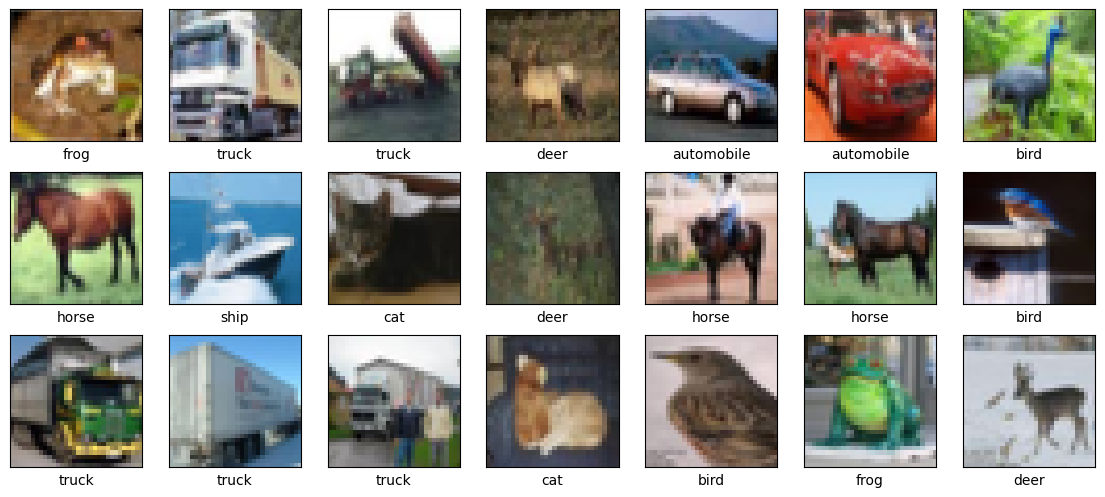

In [16]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
filter_list = [[64] * 3 + [128] * 4 + [256] * 6 + [512] * 3]
filter_list = [item for sub_list in filter_list for item in sub_list]
for filters in filter_list:
  # [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 residual_unit_16 (Residual  (None, 4, 4, 64)          78592     
 Unit)                                                           
                                                      

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
 126/1563 [=>............................] - ETA: 1:18 - loss: 2.4112 - accuracy: 0.2557

KeyboardInterrupt: ignored

## Exercise 8: CIFAR10 with data augmentation

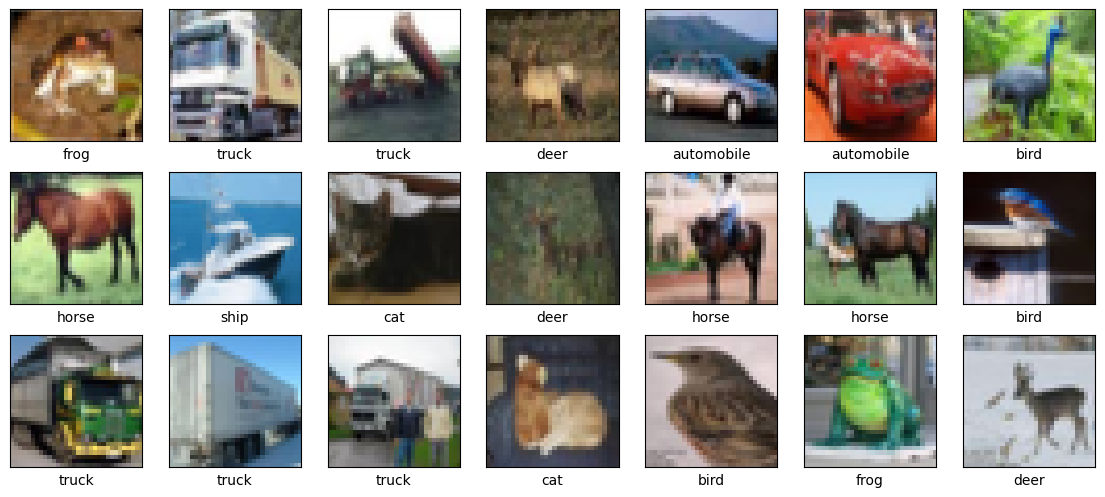

In [20]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

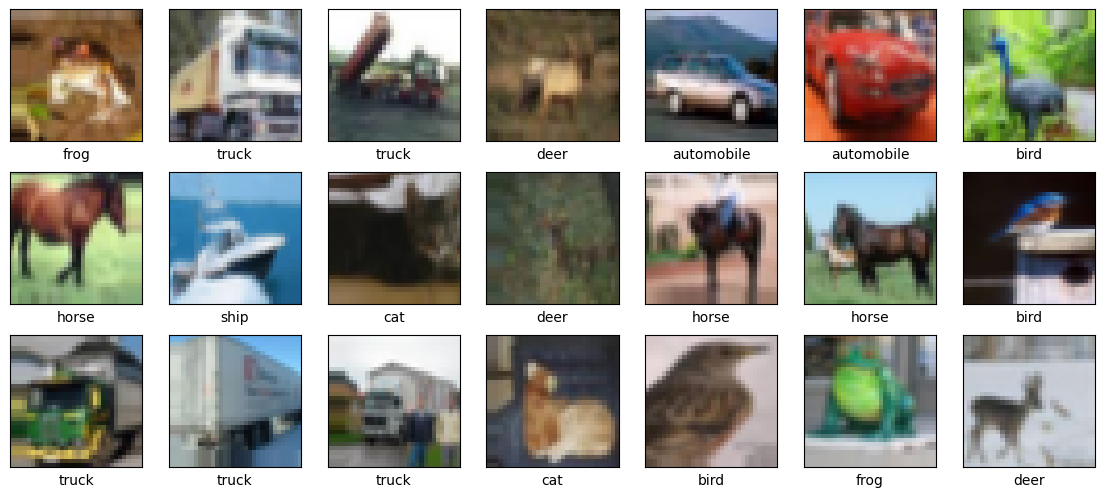

In [21]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 110s 55ms/step - loss: 0.9550 - accuracy: 0.6730 - val_loss: 1.0054 - val_accuracy: 0.6505
Epoch 2/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.8664 - accuracy: 0.7026 - val_loss: 0.9313 - val_accuracy: 0.6818
Epoch 3/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.7923 - accuracy: 0.7275 - val_loss: 1.2828 - val_accuracy: 0.5870
Epoch 4/10
1563/1563 [==============================] - 87s 56ms/step - loss: 0.7409 - accuracy: 0.7474 - val_loss: 2.6572 - val_accuracy: 0.2888
Epoch 5/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.7690 - accuracy: 0.7371 - val_loss: 1.2108 - val_accuracy: 0.6168
Epoch 6/10
1563/1563 [==============================] - 89s 57ms/step - loss: 0.7533 - accuracy: 0.7409 - val_loss: 0.8688 - val_accuracy: 0.7083
Epoch 7/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.5810 - accuracy: 0.7995 - val_loss: 0.8814 

# Task

## Task 1: Build ResNet-50 with `ResidualUnit50`
You need to fill in the blank in `#FIXIT`
- Build your `ResidualUnit50` class for ResNet-50
- Build your model with `ResidualUnit50`

Remind: **The number of class in CIFAR100 is 100.** Input shape is the same as CIFAR10

In [ ]:
class CustomResidualUnit(keras.layers.Layer):  # Custom implementation inspired by ResNet-50
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters // 4, 1, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters // 4, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 1, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]

        self.skip_layers = []  # Implementing skip connection
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:  # Incorporating skip connection layers
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32, 32, 3], padding="same", use_bias=False)) ## Answer Here change None
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 0
filter_list = [64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512] ## Answer Here
for filters in filter_list:
  strides = 1 if filters == prev_filters else 2
  model.add(CustomResidualUnit(filters, strides=strides))  # Answer Here
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="softmax")) # Answer Here


## Task 2: Training ResNet-50 for CIFAR100

Hint: The image shape of CIFAR100 is the same as CIFAR 10, but it has 10 categories.

In [ ]:
# Loading CIFAR100 dataset and preparing class names
categories = [
    "beaver", "dolphin", "otter", "seal", "whale",
    "aquarium fish", "flatfish", "ray", "shark", "trout",
    "orchids", "poppies", "roses", "sunflowers", "tulips",
    "bottles", "bowls", "cans", "cups", "plates",
    "apples", "mushrooms", "oranges", "pears", "sweet peppers",
    "clock", "computer keyboard", "lamp", "telephone", "television",
    "bed", "chair", "couch", "table", "wardrobe",
    "bee", "beetle", "butterfly", "caterpillar", "cockroach",
    "bear", "leopard", "lion", "tiger", "wolf",
    "bridge", "castle", "house", "road", "skyscraper",
    "cloud", "forest", "mountain", "plain", "sea",
    "camel", "cattle", "chimpanzee", "elephant", "kangaroo",
    "fox", "porcupine", "possum", "raccoon", "skunk",
    "crab", "lobster", "snail", "spider", "worm",
    "baby", "boy", "girl", "man", "woman",
    "crocodile", "dinosaur", "lizard", "snake", "turtle",
    "hamster", "mouse", "rabbit", "shrew", "squirrel",
    "maple", "oak", "palm", "pine", "willow",
    "bicycle", "bus", "motorcycle", "pickup truck", "train",
    "lawn-mower", "rocket", "streetcar", "tank", "tractor"
]

num_categories = len(categories)

# Loading CIFAR100 dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Normalizing pixel values to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Converting labels to one-hot encoded format
train_labels = to_categorical(train_labels, num_categories)
test_labels = to_categorical(test_labels, num_categories)

# Data augmentation using ImageDataGenerator
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=3/32,
    height_shift_range=3/32,
)
data_generator.fit(train_images)


169001437/169001437 [==============================] - 10s 0us/step


In [22]:
y_test_.shape

NameError: ignored

In [25]:
model.compile(loss="categorical_crossentropy", optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test,y_test))
score = model.evaluate(x_test, y_test)
x_new = x_test[:3] # pretend we have new images
y_pred = model.predict(x_new)

Epoch 1/3
1563/1563 [==============================] - 115s 58ms/step - loss: 1.5970 - accuracy: 0.4268 - val_loss: 2.2115 - val_accuracy: 0.3545
Epoch 2/3
1563/1563 [==============================] - 87s 56ms/step - loss: 1.2421 - accuracy: 0.5636 - val_loss: 1.3808 - val_accuracy: 0.5389
Epoch 3/3
1/1 [==============================] - 1s 733ms/step


## Task 3
Test your trained ResNet-50 model on test dataset and show that quantitative (e.g. accuracy, F1 score etc.) and qualitative(e.g. visualize test result) analysis on it

In [26]:
# Sample analysis code
# Reference:https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

f1_score = tf.keras.metrics.F1Score(average="macro")
y_test = y_test.astype(np.int32)
f1_score.update_state(y_test[:10], y_pred)
print(f1_score().result())

InvalidArgumentError: ignored



```
`# This is formatted as code`
```



In [15]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Weighted F1 Score: {f1}')

ValueError: ignored